In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


==> Loading LC25000...
Loading lung_aca...


lung_aca: 100%|██████████| 100/100 [00:00<00:00, 193.40it/s]


Loading lung_n...


lung_n: 100%|██████████| 100/100 [00:00<00:00, 118.86it/s]


Loading lung_sq...


lung_sq: 100%|██████████| 100/100 [00:00<00:00, 163.13it/s]


Loading colon_aca...


colon_aca: 100%|██████████| 100/100 [00:00<00:00, 153.85it/s]


Loading colon_n...


colon_n: 100%|██████████| 100/100 [00:00<00:00, 211.71it/s]


==> Loading BCCD...
Loading EOSINOPHIL...


EOSINOPHIL: 100%|██████████| 100/100 [00:00<00:00, 220.26it/s]


Loading LYMPHOCYTE...


LYMPHOCYTE: 100%|██████████| 100/100 [00:00<00:00, 135.22it/s]


Loading MONOCYTE...


MONOCYTE: 100%|██████████| 100/100 [00:00<00:00, 135.76it/s]


Loading NEUTROPHIL...


NEUTROPHIL: 100%|██████████| 100/100 [00:00<00:00, 284.26it/s]


Loading RBC...


RBC: 100%|██████████| 100/100 [00:00<00:00, 249.99it/s]


LC25000 Loaded: (500, 224, 224, 3) (array([0, 1, 2, 3, 4]), array([100, 100, 100, 100, 100]))
BCCD Loaded: (500, 224, 224, 3) (array([0, 1, 2, 3, 4]), array([100, 100, 100, 100, 100]))
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

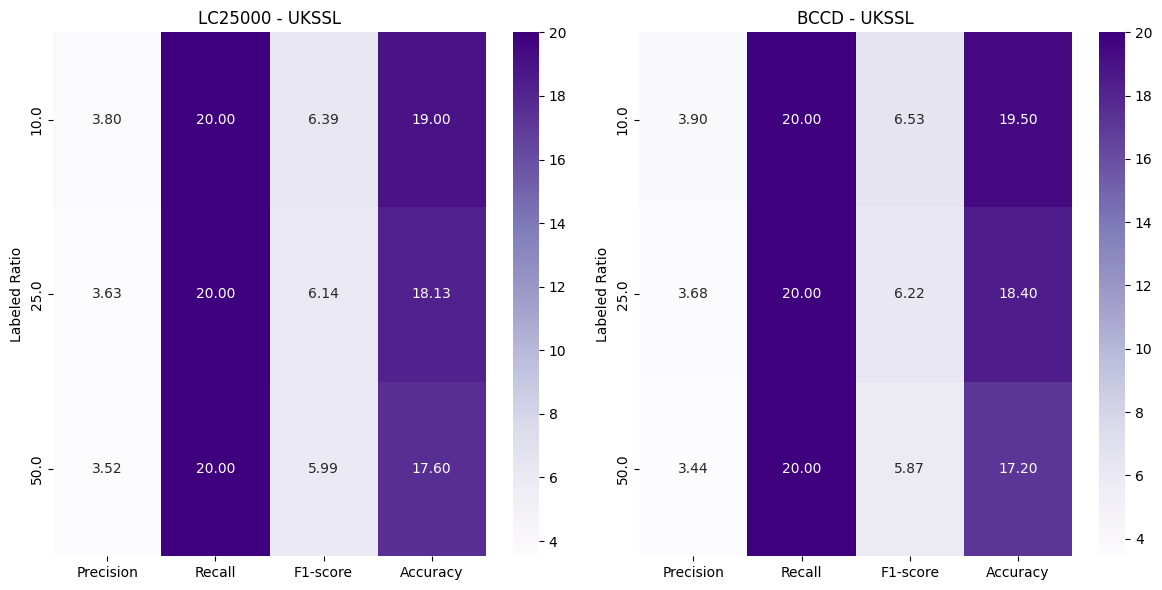


LC25000 Performance:
 Labeled Ratio  Precision  Recall  F1-score  Accuracy
          10.0   3.800000    20.0  6.386555 19.000000
          25.0   3.626667    20.0  6.139955 18.133333
          50.0   3.520000    20.0  5.986395 17.600000

BCCD Performance:
 Labeled Ratio  Precision  Recall  F1-score  Accuracy
          10.0       3.90    20.0  6.527197      19.5
          25.0       3.68    20.0  6.216216      18.4
          50.0       3.44    20.0  5.870307      17.2


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow import keras
from tensorflow.keras import layers

# -----------------------------
# Safe loader with error skipping
# -----------------------------
def safe_load_dataset(root_path, label_map, resize=(224, 224), verbose=True):
    X, y = [], []
    for label_name, label_id in label_map.items():
        full_path = os.path.join(root_path, label_name)
        if not os.path.exists(full_path):
            print(f"Skipping missing folder: {full_path}")
            continue
        image_files = os.listdir(full_path)
        if verbose:
            print(f"Loading {label_name}...")
        for fname in tqdm(image_files, desc=f"{label_name}"):
            try:
                with Image.open(os.path.join(full_path, fname)) as img:
                    img = img.convert("RGB").resize(resize)
                    X.append(np.array(img) / 255.0)
                    y.append(label_id)
            except (UnidentifiedImageError, OSError, ValueError):
                print(f"Corrupt image skipped: {fname}")
    return np.array(X), np.array(y)

# -----------------------------
# Encoder (SimCLR-style)
# -----------------------------
def build_encoder():
    base = keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3), pooling="avg")
    inputs = keras.Input(shape=(224,224,3))
    features = base(inputs)
    projection = layers.Dense(128, activation="relu")(features)
    return keras.Model(inputs, projection)

# -----------------------------
# UKMLP Classifier
# -----------------------------
def build_classifier(num_classes):
    model = keras.Sequential()
    model.add(layers.Input(shape=(128,)))
    for _ in range(12):
        model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(num_classes, activation="softmax"))
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# -----------------------------
# Evaluation Pipeline
# -----------------------------
def evaluate_model(X, y, dataset_name, label_ratio):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X, y = X[indices], y[indices]

    n_labeled = max(100, int(len(X) * label_ratio))
    if len(X) - n_labeled < 100:
        print(f"[Warning] Not enough test data in {dataset_name} for ratio {label_ratio}. Skipping.")
        return [label_ratio * 100, 0, 0, 0, 0]

    X_labeled, y_labeled = X[:n_labeled], y[:n_labeled]
    X_test, y_test = X[n_labeled:], y[n_labeled:]

    encoder = build_encoder()
    X_train_encoded = encoder.predict(X_labeled, verbose=0)
    X_test_encoded = encoder.predict(X_test, verbose=0)

    clf = build_classifier(num_classes=len(np.unique(y)))
    clf.fit(X_train_encoded, y_labeled, epochs=5, batch_size=32, verbose=0)
    y_pred = np.argmax(clf.predict(X_test_encoded, verbose=0), axis=1)

    return [
        label_ratio * 100,
        precision_score(y_test, y_pred, average="macro") * 100,
        recall_score(y_test, y_pred, average="macro") * 100,
        f1_score(y_test, y_pred, average="macro") * 100,
        accuracy_score(y_test, y_pred) * 100,
    ]

# -----------------------------
# Main Execution
# -----------------------------
# Adjust these to your actual mounted paths
lc25000_root = "/content/drive/MyDrive/Datasets/sample_LC25000"
bccd_root = "/content/drive/MyDrive/Datasets/sample_BCCD"

# Label Map for LC25000
lc_label_map = {
    "lung_aca": 0,
    "lung_n": 1,
    "lung_sq": 2,
    "colon_aca": 3,
    "colon_n": 4,
}

# Label Map for BCCD
bccd_label_map = {
    "EOSINOPHIL": 0,
    "LYMPHOCYTE": 1,
    "MONOCYTE": 2,
    "NEUTROPHIL": 3,
    "RBC": 4
}

# Load LC25000 dataset
print("==> Loading LC25000...")
X_lc, y_lc = safe_load_dataset(lc25000_root, lc_label_map)

# Load BCCD dataset
print("==> Loading BCCD...")
X_bccd, y_bccd = safe_load_dataset(bccd_root, bccd_label_map)

print("LC25000 Loaded:", X_lc.shape, np.unique(y_lc, return_counts=True))
print("BCCD Loaded:", X_bccd.shape, np.unique(y_bccd, return_counts=True))

# Run Evaluation for LC25000 and BCCD for different labeled ratios
results_lc = [evaluate_model(X_lc, y_lc, "LC25000", r) for r in [0.1, 0.25, 0.5]]
results_bccd = [evaluate_model(X_bccd, y_bccd, "BCCD", r) for r in [0.1, 0.25, 0.5]]

# Display the results in DataFrames
df_lc = pd.DataFrame(results_lc, columns=["Labeled Ratio", "Precision", "Recall", "F1-score", "Accuracy"])
df_bccd = pd.DataFrame(results_bccd, columns=["Labeled Ratio", "Precision", "Recall", "F1-score", "Accuracy"])

# Visualizing the results
plt.figure(figsize=(12,6))

# LC25000 Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(df_lc.set_index("Labeled Ratio"), annot=True, fmt=".2f", cmap="Purples")
plt.title("LC25000 - UKSSL")

# BCCD Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(df_bccd.set_index("Labeled Ratio"), annot=True, fmt=".2f", cmap="Purples")
plt.title("BCCD - UKSSL")

plt.tight_layout()
plt.show()

# Print the evaluation results
print("\nLC25000 Performance:")
print(df_lc.to_string(index=False))

print("\nBCCD Performance:")
print(df_bccd.to_string(index=False))
